In [1]:
#いろいろインポート
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression as LR

import datetime

pd.set_option('display.width',400)#勝手に改行コードを入れられるのを防ぐ

### dateのカラムから分布や時期の基礎集計と新規変数の検討

In [2]:
#モデルスコアデータの読み込み
place='suminoe'
train_df = pd.read_csv('../csv/train_{}.csv'.format(place))
train_df=train_df.drop(["Unnamed: 0"],axis=1)#csvファイルについている名無しの列を削除
train_df['date']=pd.to_datetime(train_df['date'])#文字列なのでdateを日付型に変換
display(train_df)

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_5_rank,racer_6_ID,racer_6_age,racer_6_ave_st,racer_6_bo,racer_6_doub,racer_6_male,racer_6_mo,racer_6_rank,result_com
0,2012-04-09,4410.0,1,3006,55.0,0.20,78.0,0.171,1,65.0,...,2,4597,28.0,0.18,27.0,0.012,1,57.0,1,66
1,2012-04-09,3050.0,2,2223,68.0,0.22,33.0,0.144,1,60.0,...,1,4665,29.0,0.16,68.0,0.041,1,68.0,1,26
2,2012-04-09,980.0,3,3536,46.0,0.17,8.0,0.391,1,75.0,...,3,4649,28.0,0.21,37.0,0.100,1,38.0,2,22
3,2012-04-09,2080.0,4,3633,42.0,0.18,24.0,0.113,1,40.0,...,2,3689,42.0,0.24,52.0,0.175,1,23.0,2,29
4,2012-04-09,1060.0,5,3619,39.0,0.20,38.0,0.328,1,15.0,...,4,4090,32.0,0.13,3.0,0.494,1,81.0,4,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18515,2020-03-25,510.0,8,3963,41.0,0.15,13.0,0.456,1,62.0,...,2,4211,37.0,0.17,64.0,0.230,1,13.0,2,5
18516,2020-03-25,2340.0,9,4441,34.0,0.13,34.0,0.419,1,58.0,...,2,4100,41.0,0.18,11.0,0.376,1,30.0,2,9
18517,2020-03-25,1940.0,10,4391,34.0,0.14,12.0,0.536,1,65.0,...,3,4126,41.0,0.16,38.0,0.208,1,60.0,2,3
18518,2020-03-25,1930.0,11,4247,38.0,0.16,69.0,0.333,1,57.0,...,3,3800,46.0,0.15,54.0,0.428,1,61.0,4,21


In [3]:
train_df

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_5_rank,racer_6_ID,racer_6_age,racer_6_ave_st,racer_6_bo,racer_6_doub,racer_6_male,racer_6_mo,racer_6_rank,result_com
0,2012-04-09,4410.0,1,3006,55.0,0.20,78.0,0.171,1,65.0,...,2,4597,28.0,0.18,27.0,0.012,1,57.0,1,66
1,2012-04-09,3050.0,2,2223,68.0,0.22,33.0,0.144,1,60.0,...,1,4665,29.0,0.16,68.0,0.041,1,68.0,1,26
2,2012-04-09,980.0,3,3536,46.0,0.17,8.0,0.391,1,75.0,...,3,4649,28.0,0.21,37.0,0.100,1,38.0,2,22
3,2012-04-09,2080.0,4,3633,42.0,0.18,24.0,0.113,1,40.0,...,2,3689,42.0,0.24,52.0,0.175,1,23.0,2,29
4,2012-04-09,1060.0,5,3619,39.0,0.20,38.0,0.328,1,15.0,...,4,4090,32.0,0.13,3.0,0.494,1,81.0,4,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18515,2020-03-25,510.0,8,3963,41.0,0.15,13.0,0.456,1,62.0,...,2,4211,37.0,0.17,64.0,0.230,1,13.0,2,5
18516,2020-03-25,2340.0,9,4441,34.0,0.13,34.0,0.419,1,58.0,...,2,4100,41.0,0.18,11.0,0.376,1,30.0,2,9
18517,2020-03-25,1940.0,10,4391,34.0,0.14,12.0,0.536,1,65.0,...,3,4126,41.0,0.16,38.0,0.208,1,60.0,2,3
18518,2020-03-25,1930.0,11,4247,38.0,0.16,69.0,0.333,1,57.0,...,3,3800,46.0,0.15,54.0,0.428,1,61.0,4,21


In [4]:
#新規変数の追加（月番号(month)、num_date,range_date）
#dateの型変換したものから月、年の情報の抽出
train_df['year']=train_df['date'].dt.year
train_df['month']=train_df['date'].dt.month
train_df['day']=train_df['date'].dt.day

#何日間の大会なのか(range_date)と大会(num_date)の何日目なのかの情報を追加

num_date=1
num_date_arr=[]
last_race_date=train_df['date'].values[0]#前レースの日付(処理開始時用にtarainのデータの一番初めのdateを仮に入力しておく)
for index,row in train_df.iterrows():
    today_date=row['date']
    if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
        next_date=row['date'] + datetime.timedelta(days=1)#次の日
        num_date_arr.append(num_date)
    else:#日にちが変わった時
        if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して、そのレース日番号を加算
            num_date+=1
            num_date_arr.append(num_date)
            last_race_date=row['date']#前回レース日を上書き
            #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            next_date=row['date'] + datetime.timedelta(days=1)#次の日
            #print(next_date)
        else:#想定していた日付でない(違う大会になった)場合はレース日をリセット
            num_date=1
            num_date_arr.append(num_date)
            last_race_date=row['date']#前回レース日を上書き
            #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            next_date=row['date'] + datetime.timedelta(days=1)#次の日

            
train_df['num_date']=num_date_arr
#train_df['range_date']=

In [5]:
train_df

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_bo,racer_6_doub,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date
0,2012-04-09,4410.0,1,3006,55.0,0.20,78.0,0.171,1,65.0,...,27.0,0.012,1,57.0,1,66,2012,4,9,1
1,2012-04-09,3050.0,2,2223,68.0,0.22,33.0,0.144,1,60.0,...,68.0,0.041,1,68.0,1,26,2012,4,9,1
2,2012-04-09,980.0,3,3536,46.0,0.17,8.0,0.391,1,75.0,...,37.0,0.100,1,38.0,2,22,2012,4,9,1
3,2012-04-09,2080.0,4,3633,42.0,0.18,24.0,0.113,1,40.0,...,52.0,0.175,1,23.0,2,29,2012,4,9,1
4,2012-04-09,1060.0,5,3619,39.0,0.20,38.0,0.328,1,15.0,...,3.0,0.494,1,81.0,4,56,2012,4,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18515,2020-03-25,510.0,8,3963,41.0,0.15,13.0,0.456,1,62.0,...,64.0,0.230,1,13.0,2,5,2020,3,25,6
18516,2020-03-25,2340.0,9,4441,34.0,0.13,34.0,0.419,1,58.0,...,11.0,0.376,1,30.0,2,9,2020,3,25,6
18517,2020-03-25,1940.0,10,4391,34.0,0.14,12.0,0.536,1,65.0,...,38.0,0.208,1,60.0,2,3,2020,3,25,6
18518,2020-03-25,1930.0,11,4247,38.0,0.16,69.0,0.333,1,57.0,...,54.0,0.428,1,61.0,4,21,2020,3,25,6


In [6]:
range_races=0#大会中の取得できたレースの数
range_date=1#大会の開催日数
range_date_arr=[]
range_date_arr_2=[]#for文中で繰り返し上書きさせる用の配列
last_race_date=train_df['date'].values[0]#前レースの日付(処理開始時用にtrainのデータの一番初めのdateを仮に入力しておく)
for index,row in train_df.iterrows():
    today_date=row['date']
    if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
        range_races+=1
        next_date=row['date'] + datetime.timedelta(days=1)#次の日
        #num_date_arr.append(num_date)
    else:#日にちが変わった時
        if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して終了
            range_date+=1
            range_races+=1
            last_race_date=row['date']#前回レース日を上書き
            #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            next_date=row['date'] + datetime.timedelta(days=1)#次の日次の日  
        else:#想定していた日付でない(違う大会になった)場合は現在のrange_dateをもとに前の大会のレースに大会開催日数を持たせる。

            range_date_arr_2=[range_date]*range_races
            for num in range_date_arr_2:
                range_date_arr.append(num)
            range_races=1#大会中の取得できたレースの数
            range_date=1#大会の開催日数
            last_race_date=row['date']#前回レース日を上書き
            #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            next_date=row['date'] + datetime.timedelta(days=1)#次の日
            
range_date_arr_2=[range_date]*range_races#最後の日は日付の変わり絵が発生しないので特別処理
for num in range_date_arr_2:
    range_date_arr.append(num)
train_df['range_date']=range_date_arr
#train_df['range_date']=


In [7]:
#train_df.to_csv('../csv/train_{}_date.csv'.format(place),encoding='utf-8')

分析が細かすぎるから月から四半期にスケールを大きくする。

In [8]:
#四半期カラムの作成
train_df['season']=train_df['month']
train_df['season']=train_df['season'].replace([3,4,5],'sp')#春
train_df['season']=train_df['season'].replace([6,7,8],'su')#夏
train_df['season']=train_df['season'].replace([9,10,11],'au')#秋
train_df['season']=train_df['season'].replace([12,1,2],'wi')#冬
train_df.to_csv('../csv/train_{}_date.csv'.format(place),encoding='utf-8')

In [9]:
train_df.head()

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date,range_date,season
0,2012-04-09,4410.0,1,3006,55.0,0.20,78.0,0.171,1,65.0,...,1,57.0,1,66,2012,4,9,1,7,sp
1,2012-04-09,3050.0,2,2223,68.0,0.22,33.0,0.144,1,60.0,...,1,68.0,1,26,2012,4,9,1,7,sp
2,2012-04-09,980.0,3,3536,46.0,0.17,8.0,0.391,1,75.0,...,1,38.0,2,22,2012,4,9,1,7,sp
3,2012-04-09,2080.0,4,3633,42.0,0.18,24.0,0.113,1,40.0,...,1,23.0,2,29,2012,4,9,1,7,sp
4,2012-04-09,1060.0,5,3619,39.0,0.20,38.0,0.328,1,15.0,...,1,81.0,4,56,2012,4,9,1,7,sp


In [10]:
analysis_train_df=train_df[train_df['result_com']<=24]#傾向が見たいしどうせ使わないから24以下のは消す(2-1-6まで)。
analysis_train_df


,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date,range_date,season
2,2012-04-09,980.0,3,3536,46.0,0.17,8.0,0.391,1,75.0,...,1,38.0,2,22,2012,4,9,1,7,sp
6,2012-04-09,1500.0,7,3151,48.0,0.17,54.0,0.480,1,14.0,...,1,73.0,1,6,2012,4,9,1,7,sp
7,2012-04-09,550.0,8,4259,28.0,0.17,73.0,0.395,1,85.0,...,1,78.0,2,1,2012,4,9,1,7,sp
8,2012-04-09,1270.0,9,3711,38.0,0.14,35.0,0.483,1,91.0,...,1,89.0,4,24,2012,4,9,1,7,sp
9,2012-04-09,2030.0,10,2876,55.0,0.17,16.0,0.440,1,19.0,...,1,66.0,4,6,2012,4,9,1,7,sp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18515,2020-03-25,510.0,8,3963,41.0,0.15,13.0,0.456,1,62.0,...,1,13.0,2,5,2020,3,25,6,6,sp
18516,2020-03-25,2340.0,9,4441,34.0,0.13,34.0,0.419,1,58.0,...,1,30.0,2,9,2020,3,25,6,6,sp
18517,2020-03-25,1940.0,10,4391,34.0,0.14,12.0,0.536,1,65.0,...,1,60.0,2,3,2020,3,25,6,6,sp
18518,2020-03-25,1930.0,11,4247,38.0,0.16,69.0,0.333,1,57.0,...,1,61.0,4,21,2020,3,25,6,6,sp


In [11]:
#基礎集計入りまーす(基本的な)
#年単位ざっくり
group_year_df=analysis_train_df.groupby(['year','result_com']).count()
group_year_df.to_csv('year_{}_date.csv'.format(place),encoding='utf-8')
#季節（本命）
group_season_df=analysis_train_df.groupby(['year','season','result_com']).count()
group_season_df.to_csv('season_{}_date.csv'.format(place),encoding='utf-8')
#月単位
group_month_df=analysis_train_df.groupby(['year','month','result_com']).count()
group_month_df.to_csv('month_{}_date.csv'.format(place),encoding='utf-8')

In [12]:
group_season_df.head()

date  money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_ave_st  racer_6_bo  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  month  day  num_date  range_date
year season result_com                                                                                                                         ...                                                                                                                    
2012 au     1             27     27           27          27           27              27          27            27            27          27  ...              27          27            27            27          27            27     27   27        27          27
            2             21     21           21          21           21              21          21            21            21          21  ...              21          21            21            21          21            21     21   21        21          21
            3             18     18           18          18           18              18          18            18            18          18  ...              18          18            18            18          18            18     18   18        18          18
            4             16     16           16          16           16              16          16            16            16          16  ...              16          16            16            16          16            16     16   16        16          16
            5             17     17           17          17           17              17          17            17            17          17  ...              17          17            17            17          17            17     17   17        17          17

[5 rows x 55 columns]

In [13]:
len(group_season_df['date'].values)

864

In [14]:
len(group_season_df['date'].index.levels[0])

9

# 年単位＝結果:そこまで大きく傾向は変わっていない

In [15]:
season_df=group_season_df.loc[2015:2019, :]
season_df

date  money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_ave_st  racer_6_bo  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  month  day  num_date  range_date
year season result_com                                                                                                                         ...                                                                                                                    
2015 au     1             43     43           43          43           43              43          43            43            43          43  ...              43          43            43            43          43            43     43   43        43          43
            2             30     30           30          30           30              30          30            30            30          30  ...              30          30            30            30          30            30     30   30        30          30
            3             14     14           14          14           14              14          14            14            14          14  ...              14          14            14            14          14            14     14   14        14          14
            4             15     15           15          15           15              15          15            15            15          15  ...              15          15            15            15          15            15     15   15        15          15
            5             30     30           30          30           30              30          30            30            30          30  ...              30          30            30            30          30            30     30   30        30          30
...                      ...    ...          ...         ...          ...             ...         ...           ...           ...         ...  ...             ...         ...           ...           ...         ...           ...    ...  ...       ...         ...
2019 wi     20             2      2            2           2            2               2           2             2             2           2  ...               2           2             2             2           2             2      2    2         2           2
            21             7      7            7           7            7               7           7             7             7           7  ...               7           7             7             7           7             7      7    7         7           7
            22            10     10           10          10           10              10          10            10            10          10  ...              10          10            10            10          10            10     10   10        10          10
            23             5      5            5           5            5               5           5             5             5           5  ...               5           5             5             5           5             5      5    5         5           5
            24             5      5            5           5            5               5           5             5             5           5  ...               5           5             5             5           5             5      5    5         5           5

[480 rows x 55 columns]

#### 2019

Text(0, 0.5, 'y axis')

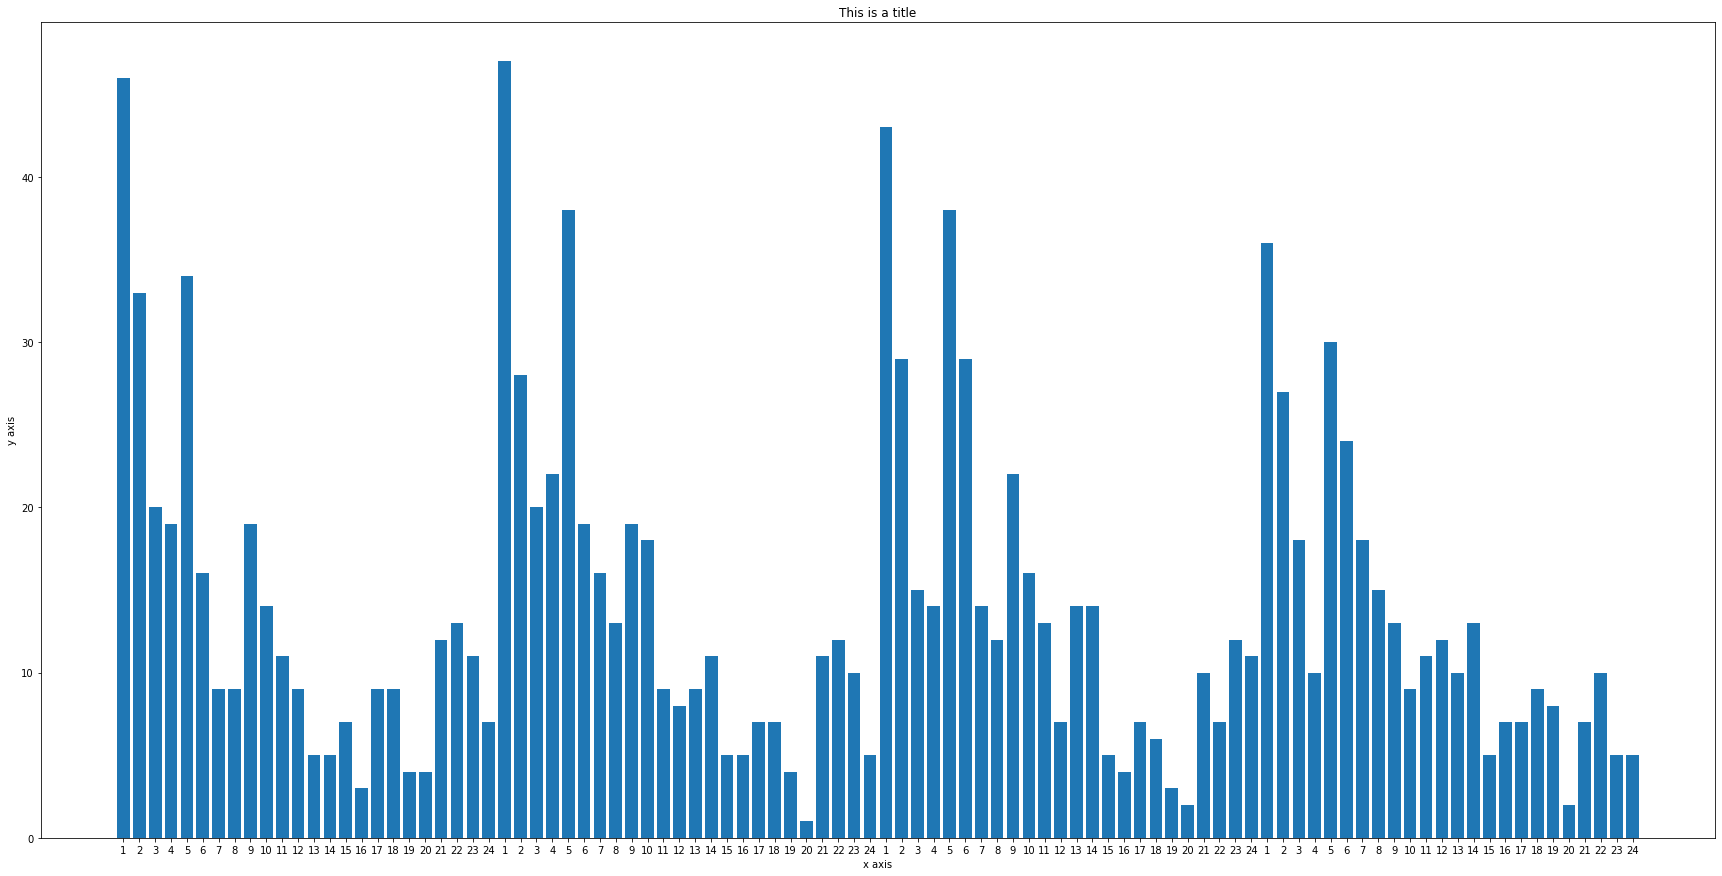

In [16]:

graph_df=season_df.loc[2019, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2018

Text(0, 0.5, 'y axis')

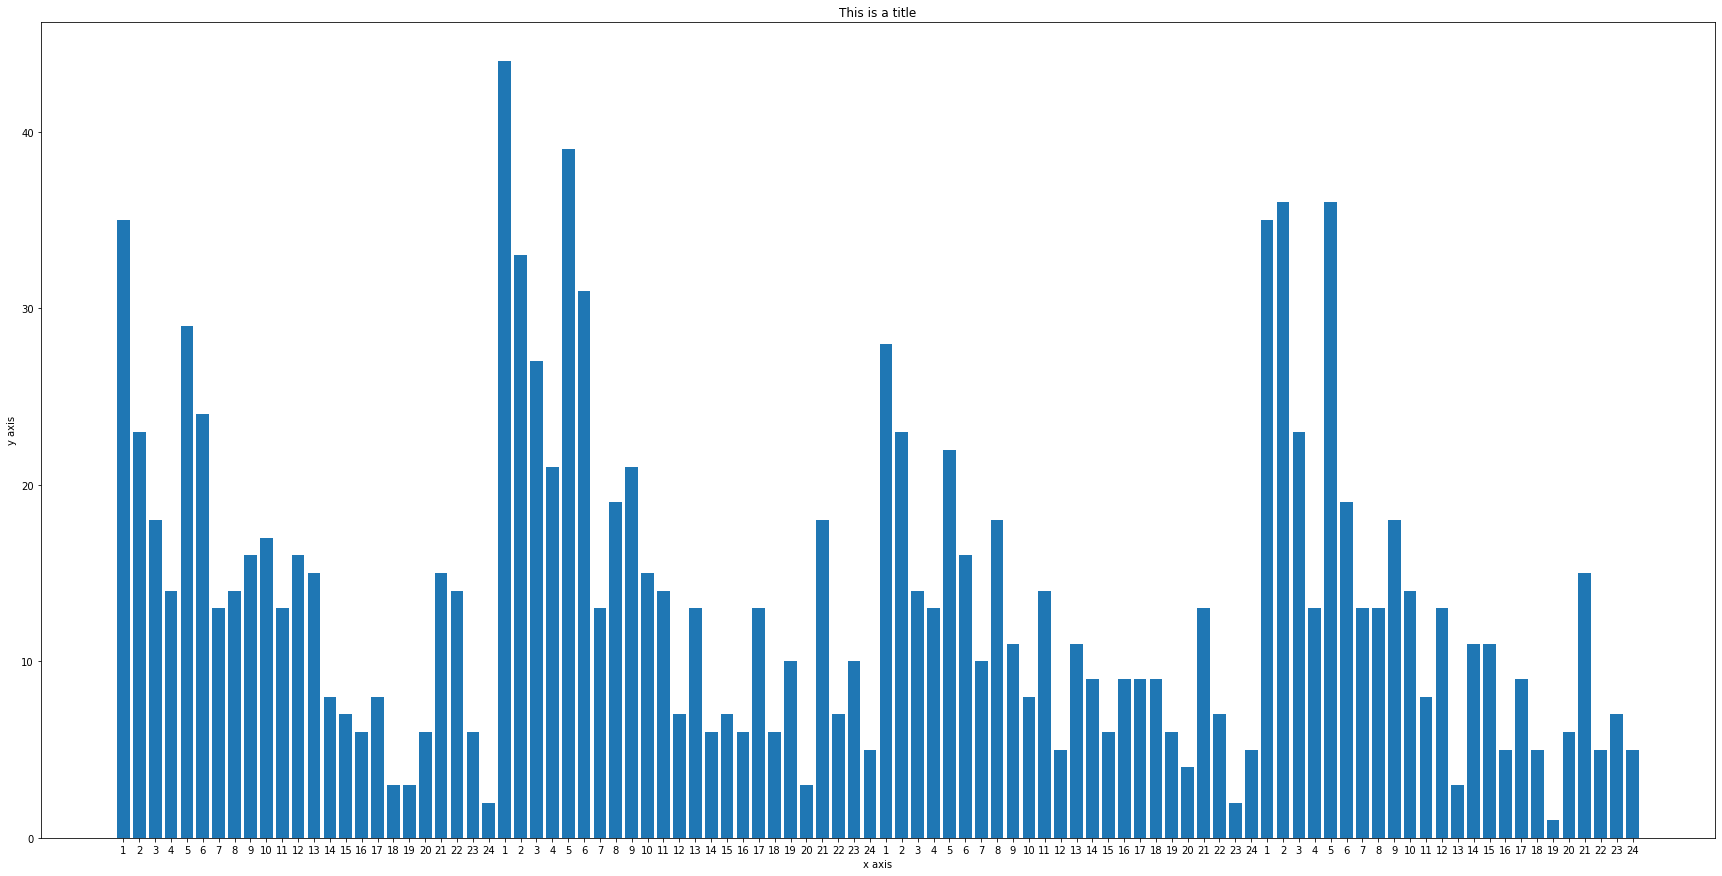

In [17]:

graph_df=season_df.loc[2018, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2017

Text(0, 0.5, 'y axis')

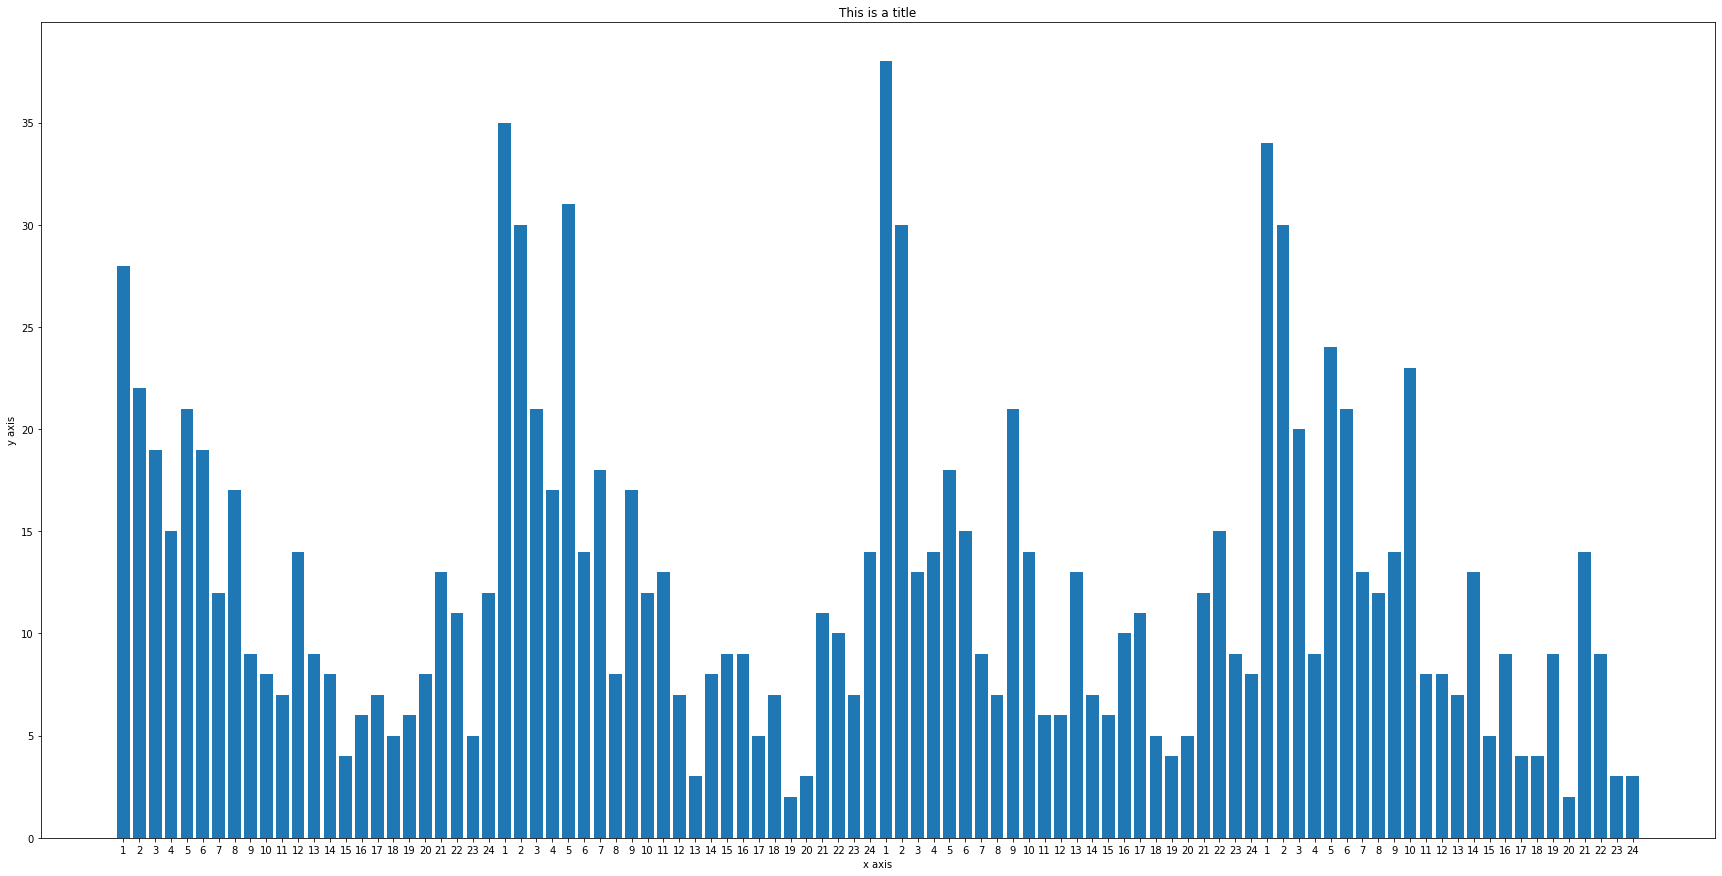

In [18]:

graph_df=season_df.loc[2017, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2015

Text(0, 0.5, 'y axis')

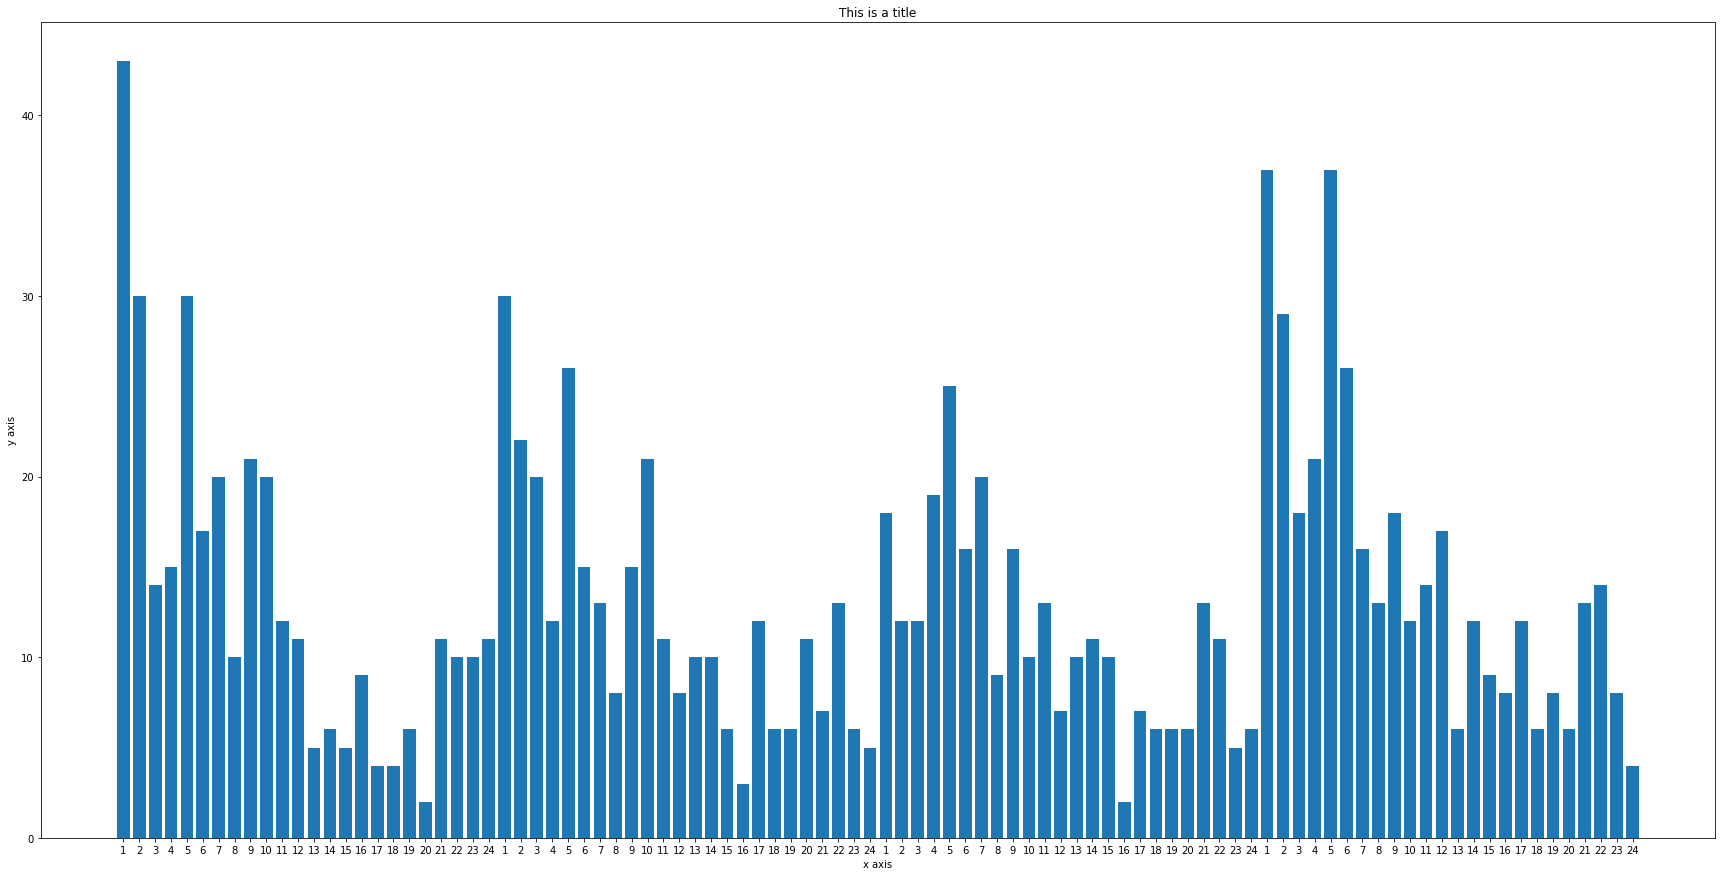

In [19]:

graph_df=season_df.loc[2015, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

# 季節　結果:

In [ ]:

graph_df=group_year_df.loc[2015:2019, :]
graph_df
plt.figure(figsize=(30,15))
#Xラベル作成
x=[]
for i in range(5):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

In [ ]:
group_season_df['date'].index.levels[2]

In [ ]:
#train_df.to_csv('test.csv',encoding='utf-8')